## Import libraries

In [1]:
#Import pandas for data manipulation (tables, cleaning, joins, etc.)
import pandas as pd
#Import numpy for numerical operations
import numpy as np
#Import matplotlib for plots/visualizations
import matplotlib.pyplot as plt
#Import seaborn for statistical visualizations (heatmap, boxplot)
import seaborn as sns 
from sklearn.preprocessing import MinMaxScaler  # for feature scaling (normalization)

## Load Dataset

In [2]:
# read the CSV file into a DataFrame
df = pd.read_csv("DengueRisk_data.csv")

## Quick Check Dengue_Weather Dataset

In [3]:
display(df.head())
print("Shape:", df.shape)
print("\nColumns:", list(df.columns))
print("\nDtypes:\n", df.dtypes)

,YearWeek,WeekStartDate,District,WeekEndDate,Cases,temp_mean_C,temp_max_C,temp_min_C,precipitation_sum (mm),rain_sum (mm),sunshine_duration (s),daylight_duration (s),wind_speed_10m_max (km/h),et0_fao_evapotranspiration (mm)
0,2022-W01,2022-01-03,ampara,2022-01-09,8,24.486,28.9,21.7,50.8,50.8,206686.56,295282.97,21.4,19.92
1,2022-W01,2022-01-03,anuradhapura,2022-01-09,12,24.971,29.9,21.9,14.1,14.1,255617.67,293795.87,20.4,24.22
2,2022-W01,2022-01-03,badulla,2022-01-09,64,21.100,24.9,18.0,78.1,78.1,179577.35,295678.42,14.5,16.71
3,2022-W01,2022-01-03,batticaloa,2022-01-09,26,25.314,28.2,23.1,67.1,67.1,237101.87,294688.95,23.6,21.62
4,2022-W01,2022-01-03,colombo,2022-01-09,563,26.214,32.0,22.8,27.9,27.9,245154.69,295777.20,22.6,29.46


Shape: (4366, 14)

Columns: ['YearWeek', 'WeekStartDate', 'District', 'WeekEndDate', 'Cases', 'temp_mean_C', 'temp_max_C', 'temp_min_C', 'precipitation_sum (mm)', 'rain_sum (mm)', 'sunshine_duration (s)', 'daylight_duration (s)', 'wind_speed_10m_max (km/h)', 'et0_fao_evapotranspiration (mm)']

Dtypes:
 YearWeek                            object
WeekStartDate                       object
District                            object
WeekEndDate                         object
Cases                                int64
temp_mean_C                        float64
temp_max_C                         float64
temp_min_C                         float64
precipitation_sum (mm)             float64
rain_sum (mm)                      float64
sunshine_duration (s)              float64
daylight_duration (s)              float64
wind_speed_10m_max (km/h)          float64
et0_fao_evapotranspiration (mm)    float64
dtype: object


In [4]:
# Count of missing values per column
missing_count = df.isna().sum()
print("Missing values per column:\n", missing_count)

Missing values per column:
 YearWeek                           0
WeekStartDate                      0
District                           0
WeekEndDate                        0
Cases                              0
temp_mean_C                        0
temp_max_C                         0
temp_min_C                         0
precipitation_sum (mm)             0
rain_sum (mm)                      0
sunshine_duration (s)              0
daylight_duration (s)              0
wind_speed_10m_max (km/h)          0
et0_fao_evapotranspiration (mm)    0
dtype: int64


## Column Cleaning & Unit Conversion

In [5]:
# 1️⃣ Rename columns for simplicity
df.rename(columns={
    'temperature_2m_mean (Â°C)': 'temp_mean_C',
    'temperature_2m_max (Â°C)': 'temp_max_C',
    'temperature_2m_min (Â°C)': 'temp_min_C',
    'rain_sum (mm)': 'rain_sum',
    'sunshine_duration (s)': 'sunshine_duration',
    'daylight_duration (s)': 'daylight_duration',
    'wind_speed_10m_max (km/h)': 'wind_speed_max',
    'et0_fao_evapotranspiration (mm)': 'et0_evapotranspiration'
}, inplace=True)

# 2️⃣ Convert WeekStartDate to datetime
df['WeekStartDate'] = pd.to_datetime(df['WeekStartDate'])

# 3️⃣ Keep only selected columns 
columns_to_keep = [
    'YearWeek', 'District', 'WeekStartDate', 'Cases',
    'temp_mean_C', 'temp_max_C', 'temp_min_C',
    'rain_sum', 'sunshine_duration', 'daylight_duration',
    'wind_speed_max', 'et0_evapotranspiration'
]
df = df[columns_to_keep]

# ✅ Preview cleaned dataset
display(df.head())
print("Columns after cleaning:", df.columns.tolist())

,YearWeek,District,WeekStartDate,Cases,temp_mean_C,temp_max_C,temp_min_C,rain_sum,sunshine_duration,daylight_duration,wind_speed_max,et0_evapotranspiration
0,2022-W01,ampara,2022-01-03,8,24.486,28.9,21.7,50.8,206686.56,295282.97,21.4,19.92
1,2022-W01,anuradhapura,2022-01-03,12,24.971,29.9,21.9,14.1,255617.67,293795.87,20.4,24.22
2,2022-W01,badulla,2022-01-03,64,21.100,24.9,18.0,78.1,179577.35,295678.42,14.5,16.71
3,2022-W01,batticaloa,2022-01-03,26,25.314,28.2,23.1,67.1,237101.87,294688.95,23.6,21.62
4,2022-W01,colombo,2022-01-03,563,26.214,32.0,22.8,27.9,245154.69,295777.20,22.6,29.46


Columns after cleaning: ['YearWeek', 'District', 'WeekStartDate', 'Cases', 'temp_mean_C', 'temp_max_C', 'temp_min_C', 'rain_sum', 'sunshine_duration', 'daylight_duration', 'wind_speed_max', 'et0_evapotranspiration']


In [6]:
# Find all duplicate rows
duplicates = df[df.duplicated()]

# Number of duplicates
print("Number of duplicate rows:", duplicates.shape[0])

# Preview duplicate rows (if any)
display(duplicates)

Number of duplicate rows: 0


,YearWeek,District,WeekStartDate,Cases,temp_mean_C,temp_max_C,temp_min_C,rain_sum,sunshine_duration,daylight_duration,wind_speed_max,et0_evapotranspiration


## Time & Unit Conversion

In [7]:
# Convert seconds to hours
df['sunshine_duration'] = df['sunshine_duration'] / 3600
df['daylight_duration'] = df['daylight_duration'] / 3600

# Preview the changes
display(df[['sunshine_duration', 'daylight_duration']].head())

,sunshine_duration,daylight_duration
0,57.412933,82.023047
1,71.004908,81.609964
2,49.882597,82.132894
3,65.861631,81.858042
4,68.098525,82.160333


## Outlier detection & IQR capping

In [8]:
# Technique: Outlier Detection & Winsorization (IQR method) ===
# List of weather/numerical features
num_features = ['temp_mean_C', 'temp_max_C', 'temp_min_C',
                'rain_sum', 'sunshine_duration', 'daylight_duration',
                'wind_speed_max', 'et0_evapotranspiration']

# Keep a copy before outlier capping (for comparison later if needed)
df_before_outliers = df.copy()

# Apply IQR-based winsorization
for feature in num_features:
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Count outliers
    outliers = df[(df[feature] < lower_bound) | (df[feature] > upper_bound)]
    print(f"{feature}: {outliers.shape[0]} outliers capped")

    # Winsorize (cap values to bounds)
    df[feature] = df[feature].clip(lower=lower_bound, upper=upper_bound)


temp_mean_C: 210 outliers capped
temp_max_C: 195 outliers capped
temp_min_C: 249 outliers capped
rain_sum: 209 outliers capped
sunshine_duration: 71 outliers capped
daylight_duration: 0 outliers capped
wind_speed_max: 84 outliers capped
et0_evapotranspiration: 17 outliers capped


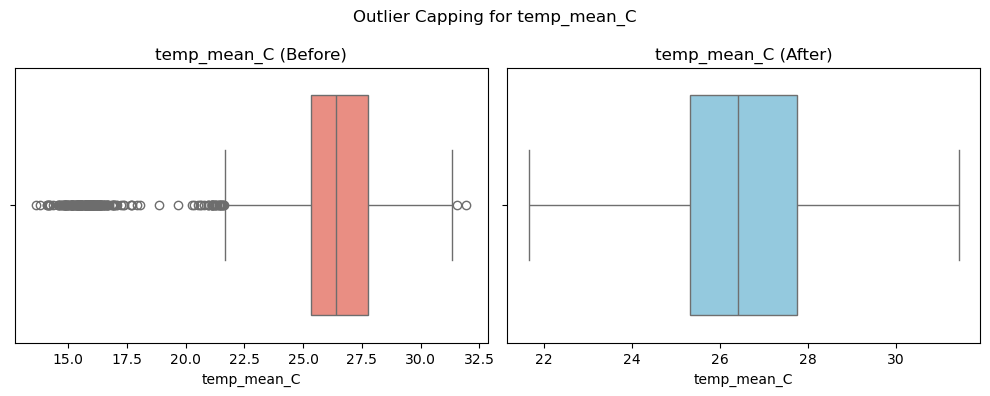

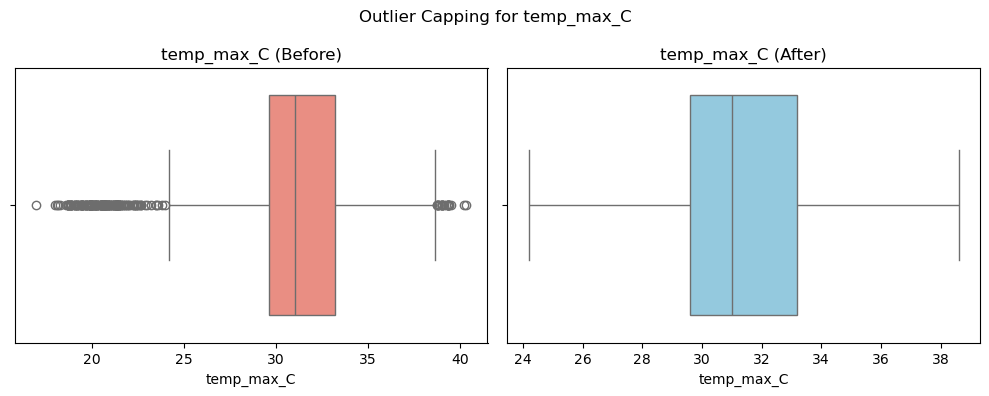

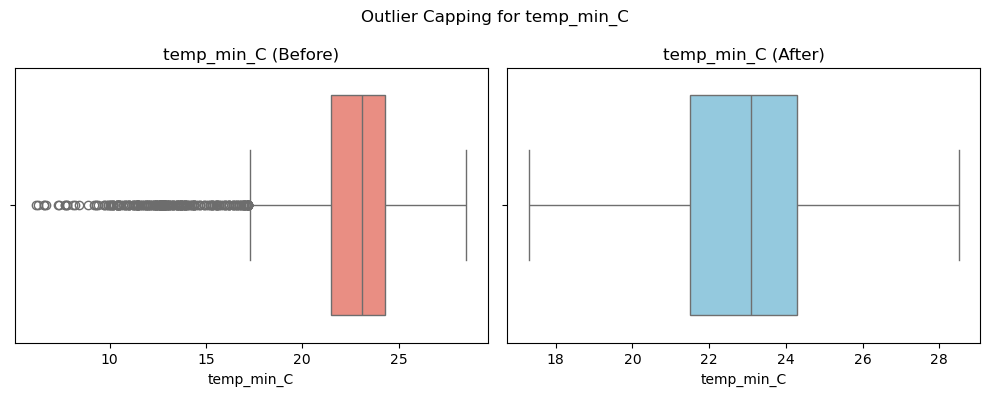

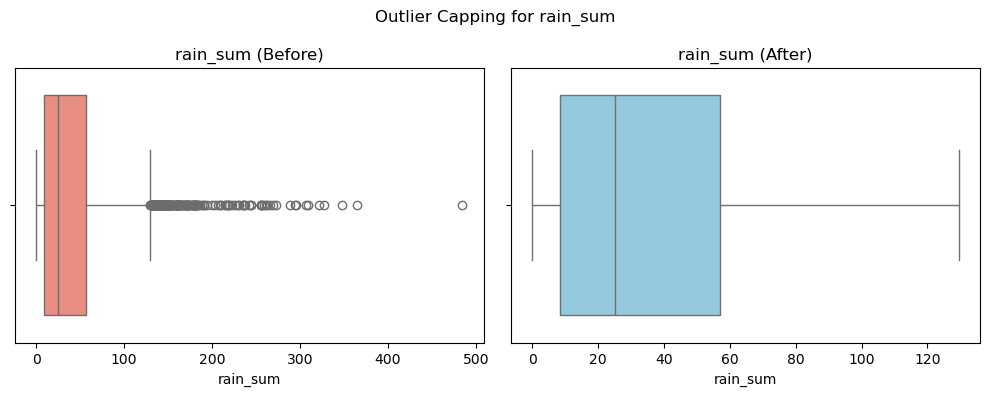

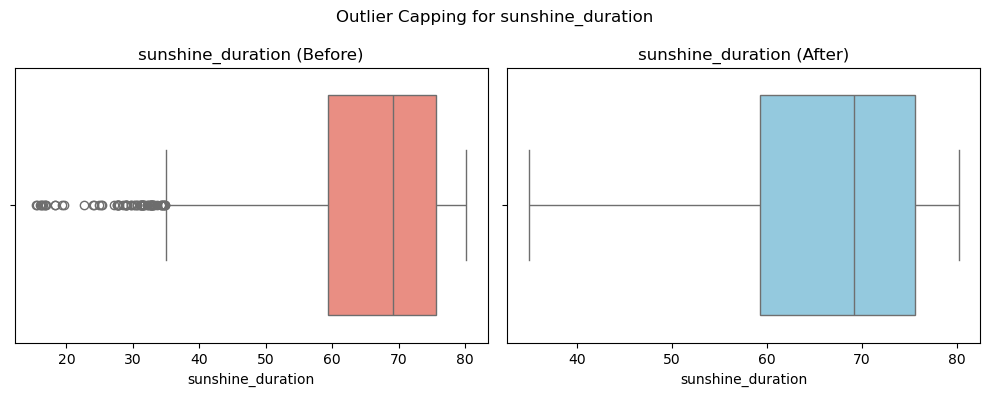

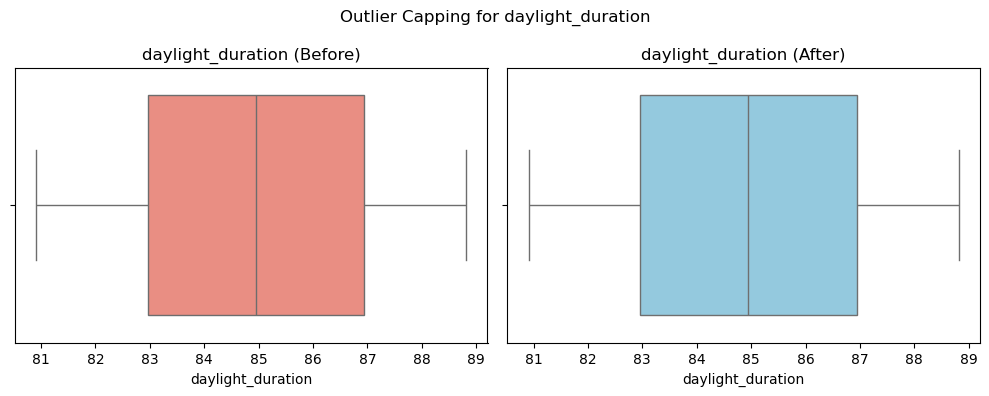

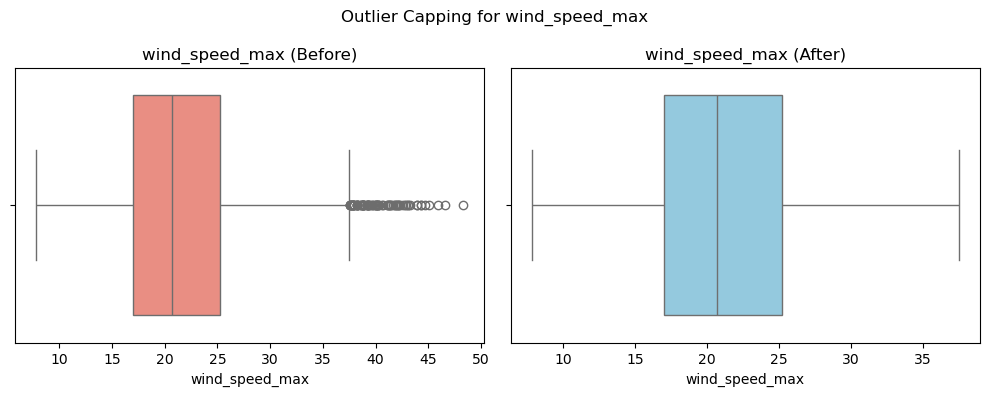

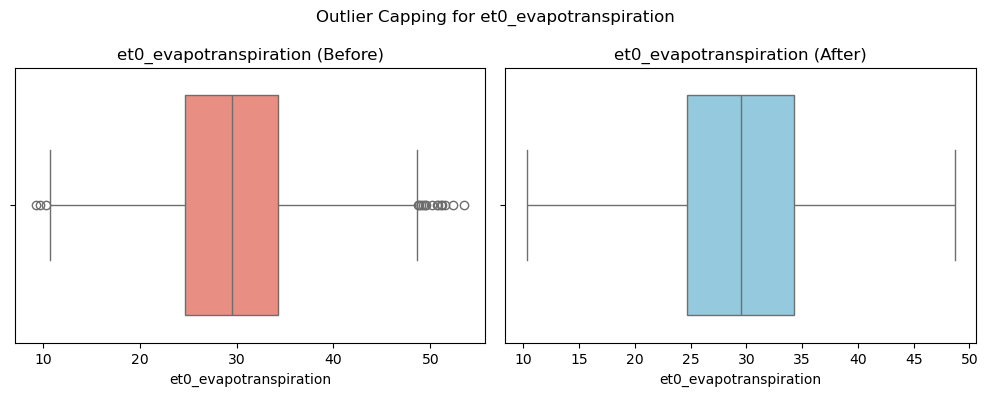

In [9]:
# Boxplots BEFORE vs AFTER capping 
import matplotlib.pyplot as plt
import seaborn as sns

for feature in num_features:
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))

    # Before capping
    sns.boxplot(x=df_before_outliers[feature], ax=ax[0], color="salmon")
    ax[0].set_title(f"{feature} (Before)")

    # After capping
    sns.boxplot(x=df[feature], ax=ax[1], color="skyblue")
    ax[1].set_title(f"{feature} (After)")

    plt.suptitle(f"Outlier Capping for {feature}", fontsize=12)
    plt.tight_layout()
    plt.show()



## Categorical encoding (district → One‑Hot)

In [10]:
# Make a copy
df_ohe = df.copy()

# Generate dummy variables for District (without removing the original column)
district_dummies = pd.get_dummies(df_ohe['District'], prefix="District", drop_first=True)

# Join dummy columns back
df_ohe = pd.concat([df_ohe, district_dummies], axis=1)

In [11]:
# ✅ Convert dummy columns from bool → int
bool_cols = df_ohe.select_dtypes('bool').columns
df_ohe[bool_cols] = df_ohe[bool_cols].astype(int)

In [12]:
# Preview columns
print(df_ohe.columns.tolist())
display(df_ohe.head())

['YearWeek', 'District', 'WeekStartDate', 'Cases', 'temp_mean_C', 'temp_max_C', 'temp_min_C', 'rain_sum', 'sunshine_duration', 'daylight_duration', 'wind_speed_max', 'et0_evapotranspiration', 'District_anuradhapura', 'District_badulla', 'District_batticaloa', 'District_colombo', 'District_galle', 'District_gampaha', 'District_hambantota', 'District_jaffna', 'District_kalmunai', 'District_kalutara', 'District_kandy', 'District_kegalle', 'District_kilinochchi', 'District_kurunegala', 'District_mannar', 'District_matale', 'District_matara', 'District_monaragala', 'District_mullaitivu', 'District_nuwara eliya', 'District_polonnaruwa', 'District_puttalam', 'District_ratnapura', 'District_trincomalee', 'District_vavuniya']


,YearWeek,District,WeekStartDate,Cases,temp_mean_C,temp_max_C,temp_min_C,rain_sum,sunshine_duration,daylight_duration,...,District_matale,District_matara,District_monaragala,District_mullaitivu,District_nuwara eliya,District_polonnaruwa,District_puttalam,District_ratnapura,District_trincomalee,District_vavuniya
0,2022-W01,ampara,2022-01-03,8,24.4860,28.9,21.7,50.8,57.412933,82.023047,...,0,0,0,0,0,0,0,0,0,0
1,2022-W01,anuradhapura,2022-01-03,12,24.9710,29.9,21.9,14.1,71.004908,81.609964,...,0,0,0,0,0,0,0,0,0,0
2,2022-W01,badulla,2022-01-03,64,21.6495,24.9,18.0,78.1,49.882597,82.132894,...,0,0,0,0,0,0,0,0,0,0
3,2022-W01,batticaloa,2022-01-03,26,25.3140,28.2,23.1,67.1,65.861631,81.858042,...,0,0,0,0,0,0,0,0,0,0
4,2022-W01,colombo,2022-01-03,563,26.2140,32.0,22.8,27.9,68.098525,82.160333,...,0,0,0,0,0,0,0,0,0,0


In [13]:
# Show a few dummy columns side by side with the original District
cols_to_show = ['District'] + list(df_ohe.filter(like='District_').columns[:5])
display(df_ohe[cols_to_show].head(10))

,District,District_anuradhapura,District_badulla,District_batticaloa,District_colombo,District_galle
0,ampara,0,0,0,0,0
1,anuradhapura,1,0,0,0,0
2,badulla,0,1,0,0,0
3,batticaloa,0,0,1,0,0
4,colombo,0,0,0,1,0
5,galle,0,0,0,0,1
6,gampaha,0,0,0,0,0
7,hambantota,0,0,0,0,0
8,jaffna,0,0,0,0,0
9,kalmunai,0,0,0,0,0


## Feature Engineering:add risk_level

In [14]:
# --- Feature Engineering: Add risk_level column ---

# District-wise 75th percentile rule on RAW Cases
df_ohe["risk_level"] = df_ohe.groupby("District")["Cases"].transform(
    lambda s: (s >= s.quantile(0.75)).astype(int)
)

# Quick check
display(df_ohe[["District", "Cases", "risk_level"]].head(10))
print("✅ risk_level counts:\n", df_ohe["risk_level"].value_counts())


,District,Cases,risk_level
0,ampara,8,1
1,anuradhapura,12,0
2,badulla,64,1
3,batticaloa,26,0
4,colombo,563,1
5,galle,95,1
6,gampaha,457,1
7,hambantota,22,0
8,jaffna,31,0
9,kalmunai,27,0


✅ risk_level counts:
 risk_level
0    3183
1    1183
Name: count, dtype: int64


In [15]:
display(df_ohe.head())

,YearWeek,District,WeekStartDate,Cases,temp_mean_C,temp_max_C,temp_min_C,rain_sum,sunshine_duration,daylight_duration,...,District_matara,District_monaragala,District_mullaitivu,District_nuwara eliya,District_polonnaruwa,District_puttalam,District_ratnapura,District_trincomalee,District_vavuniya,risk_level
0,2022-W01,ampara,2022-01-03,8,24.4860,28.9,21.7,50.8,57.412933,82.023047,...,0,0,0,0,0,0,0,0,0,1
1,2022-W01,anuradhapura,2022-01-03,12,24.9710,29.9,21.9,14.1,71.004908,81.609964,...,0,0,0,0,0,0,0,0,0,0
2,2022-W01,badulla,2022-01-03,64,21.6495,24.9,18.0,78.1,49.882597,82.132894,...,0,0,0,0,0,0,0,0,0,1
3,2022-W01,batticaloa,2022-01-03,26,25.3140,28.2,23.1,67.1,65.861631,81.858042,...,0,0,0,0,0,0,0,0,0,0
4,2022-W01,colombo,2022-01-03,563,26.2140,32.0,22.8,27.9,68.098525,82.160333,...,0,0,0,0,0,0,0,0,0,1


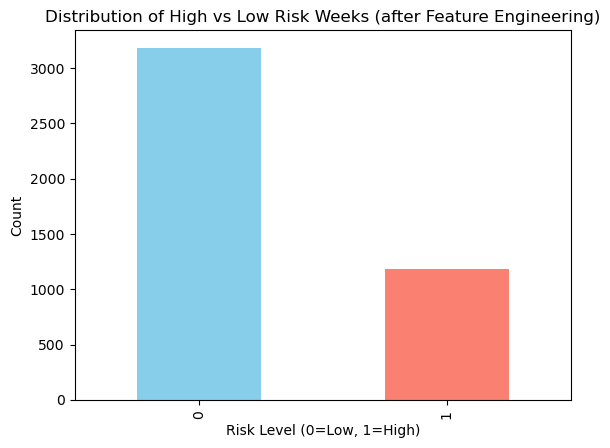

In [16]:
# Distribution of new label (risk_level)
import matplotlib.pyplot as plt

df_ohe["risk_level"].value_counts().plot(
    kind="bar", color=["skyblue", "salmon"]
)

plt.title("Distribution of High vs Low Risk Weeks (after Feature Engineering)")
plt.xlabel("Risk Level (0=Low, 1=High)")
plt.ylabel("Count")
plt.show()


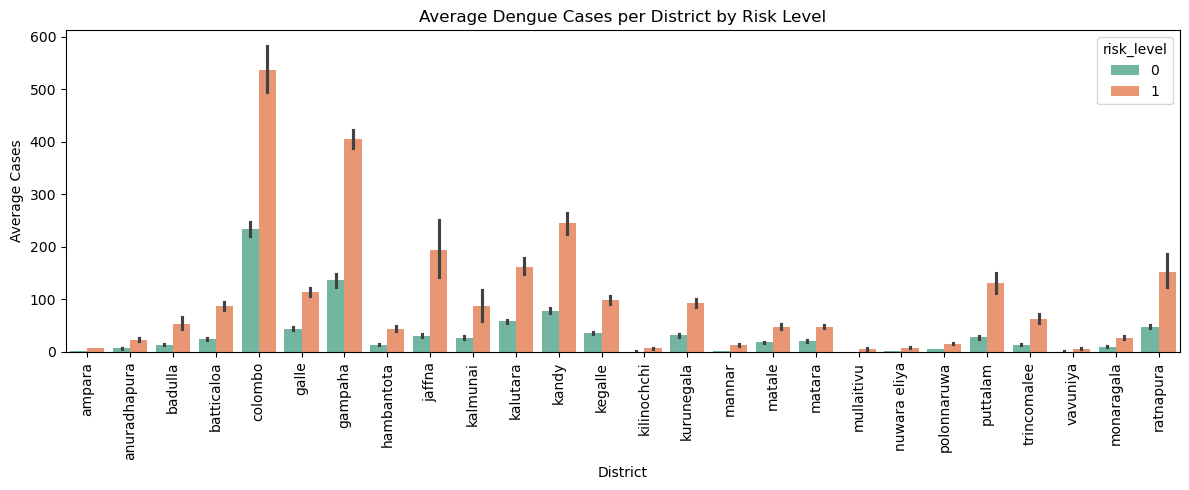

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# Average dengue cases per district, split by risk_level
plt.figure(figsize=(12,5))
sns.barplot(
    x="District", 
    y="Cases", 
    hue="risk_level", 
    data=df_ohe,          # ✅ use df_ohe, not df
    estimator="mean", 
    palette="Set2"
)

plt.title("Average Dengue Cases per District by Risk Level")
plt.xlabel("District")
plt.ylabel("Average Cases")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


## Feature Selection: Drop Coulumns

In [18]:
# Explicitly drop only the raw District/date/target columns (not one-hot encoded ones)
cols_to_drop = ["District", "WeekStartDate", "WeekEndDate", "Cases"]

# Drop only if the column name matches exactly
df_ohe = df_ohe.drop(columns=[c for c in cols_to_drop if c in df_ohe.columns], errors="ignore")

print("✅ Remaining columns (encoded District_* should still exist):")
print([c for c in df_ohe.columns if "District" in c or "district" in c])

✅ Remaining columns (encoded District_* should still exist):
['District_anuradhapura', 'District_badulla', 'District_batticaloa', 'District_colombo', 'District_galle', 'District_gampaha', 'District_hambantota', 'District_jaffna', 'District_kalmunai', 'District_kalutara', 'District_kandy', 'District_kegalle', 'District_kilinochchi', 'District_kurunegala', 'District_mannar', 'District_matale', 'District_matara', 'District_monaragala', 'District_mullaitivu', 'District_nuwara eliya', 'District_polonnaruwa', 'District_puttalam', 'District_ratnapura', 'District_trincomalee', 'District_vavuniya']


In [19]:
display(df_ohe.head())

,YearWeek,temp_mean_C,temp_max_C,temp_min_C,rain_sum,sunshine_duration,daylight_duration,wind_speed_max,et0_evapotranspiration,District_anuradhapura,...,District_matara,District_monaragala,District_mullaitivu,District_nuwara eliya,District_polonnaruwa,District_puttalam,District_ratnapura,District_trincomalee,District_vavuniya,risk_level
0,2022-W01,24.4860,28.9,21.7,50.8,57.412933,82.023047,21.4,19.92,0,...,0,0,0,0,0,0,0,0,0,1
1,2022-W01,24.9710,29.9,21.9,14.1,71.004908,81.609964,20.4,24.22,1,...,0,0,0,0,0,0,0,0,0,0
2,2022-W01,21.6495,24.9,18.0,78.1,49.882597,82.132894,14.5,16.71,0,...,0,0,0,0,0,0,0,0,0,1
3,2022-W01,25.3140,28.2,23.1,67.1,65.861631,81.858042,23.6,21.62,0,...,0,0,0,0,0,0,0,0,0,0
4,2022-W01,26.2140,32.0,22.8,27.9,68.098525,82.160333,22.6,29.46,0,...,0,0,0,0,0,0,0,0,0,1


## Scaling / normalization (StandardScaler) 

In [20]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# Start from your current working frame AFTER drops (use df_ohe if that's your pipeline)
# If you already did: df_ohe = df_ohe.drop([...]), keep using df_ohe.
# Otherwise, apply the same drop here safely:
cols_to_drop = ["District", "WeekStartDate", "WeekEndDate", "Cases"]
df_work = (df_ohe if 'df_ohe' in globals() else df).copy()
df_work = df_work.drop(columns=[c for c in cols_to_drop if c in df_work.columns], errors="ignore")

# ---- Choose columns to scale (robust auto-detection) ----
# 1) numeric columns only
num_cols = df_work.select_dtypes(include=[np.number]).columns.tolist()

# 2) exclude non-features / labels / binaries / dummies
exclude_exact = {"risk_level", "week", "year", "yearweek", "index"}  # add more if you have them
exclude_prefixes = ("District_", "district_")  # one-hot district dummies
# exclude columns that are effectively binary (0/1 or 2 unique values)
binary_like = [c for c in num_cols if df_work[c].dropna().nunique() <= 2]

to_scale = []
for c in num_cols:
    if c in exclude_exact: 
        continue
    if c.startswith(exclude_prefixes):
        continue
    if c in binary_like:
        continue
    to_scale.append(c)


# ---- Scale only the chosen columns ----
scaler = StandardScaler()
if to_scale:
    df_scaled = df_work.copy()
    df_scaled[to_scale] = scaler.fit_transform(df_scaled[to_scale])
else:
    df_scaled = df_work.copy()

print("✅ Columns scaled:", to_scale if to_scale else "None (nothing suitable found)")
if to_scale:
    summary = df_scaled[to_scale].agg(["mean", "std"]).T.round(3)
    print("\nPost-scale mean/std:\n", summary)

# df_scaled is your next dataframe to use for feature selection / modeling


✅ Columns scaled: ['temp_mean_C', 'temp_max_C', 'temp_min_C', 'rain_sum', 'sunshine_duration', 'daylight_duration', 'wind_speed_max', 'et0_evapotranspiration']

Post-scale mean/std:
                         mean  std
temp_mean_C              0.0  1.0
temp_max_C              -0.0  1.0
temp_min_C               0.0  1.0
rain_sum                -0.0  1.0
sunshine_duration       -0.0  1.0
daylight_duration        0.0  1.0
wind_speed_max          -0.0  1.0
et0_evapotranspiration  -0.0  1.0


In [21]:
# --- Verify scaling results ---

# 1. Continuous features should have mean ~0, std ~1
if to_scale:   # <-- 'to_scale' is from the scaling block
    print(df_scaled[to_scale].agg(["mean","std"]).round(3).T)
else:
    print("No continuous columns were scaled.")

# 2. District dummy columns should still be {0,1}
dummy_cols = [c for c in df_scaled.columns if c.startswith("District_") or c.startswith("district_")]
if dummy_cols:
    uniques = {c: sorted(df_scaled[c].unique().tolist()) for c in dummy_cols}
    print("\nDummy unique values (should be {0,1}):")
    for col, vals in uniques.items():
        print(f"  {col}: {vals}")
else:
    print("No dummy District columns found.")


                        mean  std
temp_mean_C              0.0  1.0
temp_max_C              -0.0  1.0
temp_min_C               0.0  1.0
rain_sum                -0.0  1.0
sunshine_duration       -0.0  1.0
daylight_duration        0.0  1.0
wind_speed_max          -0.0  1.0
et0_evapotranspiration  -0.0  1.0

Dummy unique values (should be {0,1}):
  District_anuradhapura: [0, 1]
  District_badulla: [0, 1]
  District_batticaloa: [0, 1]
  District_colombo: [0, 1]
  District_galle: [0, 1]
  District_gampaha: [0, 1]
  District_hambantota: [0, 1]
  District_jaffna: [0, 1]
  District_kalmunai: [0, 1]
  District_kalutara: [0, 1]
  District_kandy: [0, 1]
  District_kegalle: [0, 1]
  District_kilinochchi: [0, 1]
  District_kurunegala: [0, 1]
  District_mannar: [0, 1]
  District_matale: [0, 1]
  District_matara: [0, 1]
  District_monaragala: [0, 1]
  District_mullaitivu: [0, 1]
  District_nuwara eliya: [0, 1]
  District_polonnaruwa: [0, 1]
  District_puttalam: [0, 1]
  District_ratnapura: [0, 1]
  D

In [22]:
from IPython.display import display

# Preview scaled dataset (first 5 rows)
print("✅ Scaled dataset preview:")
display(df_scaled.head())

# If you want to compare before vs after for selected continuous features
compare_cols = ["temp_mean_C", "rain_sum"]

print("\nBefore scaling (df_ohe):")
display(df_ohe[[c for c in compare_cols if c in df_ohe.columns]].head())

print("\nAfter scaling (df_scaled):")
display(df_scaled[[c for c in compare_cols if c in df_scaled.columns]].head())


✅ Scaled dataset preview:


,YearWeek,temp_mean_C,temp_max_C,temp_min_C,rain_sum,sunshine_duration,daylight_duration,wind_speed_max,et0_evapotranspiration,District_anuradhapura,...,District_matara,District_monaragala,District_mullaitivu,District_nuwara eliya,District_polonnaruwa,District_puttalam,District_ratnapura,District_trincomalee,District_vavuniya,risk_level
0,2022-W01,-0.959489,-0.849928,-0.423251,0.339925,-0.745342,-1.376816,-0.014035,-1.440448,0,...,0,0,0,0,0,0,0,0,0,1
1,2022-W01,-0.715774,-0.502382,-0.337936,-0.646809,0.438579,-1.570933,-0.174945,-0.804776,1,...,0,0,0,0,0,0,0,0,0,0
2,2022-W01,-2.384842,-2.240112,-2.001570,1.073927,-1.401267,-1.325196,-1.124318,-1.914984,0,...,0,0,0,0,0,0,0,0,0,1
3,2022-W01,-0.543415,-1.093210,0.173951,0.778175,-0.009423,-1.454355,0.339969,-1.189135,0,...,0,0,0,0,0,0,0,0,0,0
4,2022-W01,-0.091161,0.227465,0.045979,-0.275776,0.185420,-1.312302,0.179058,-0.030144,0,...,0,0,0,0,0,0,0,0,0,1



Before scaling (df_ohe):


,temp_mean_C,rain_sum
0,24.4860,50.8
1,24.9710,14.1
2,21.6495,78.1
3,25.3140,67.1
4,26.2140,27.9



After scaling (df_scaled):


,temp_mean_C,rain_sum
0,-0.959489,0.339925
1,-0.715774,-0.646809
2,-2.384842,1.073927
3,-0.543415,0.778175
4,-0.091161,-0.275776


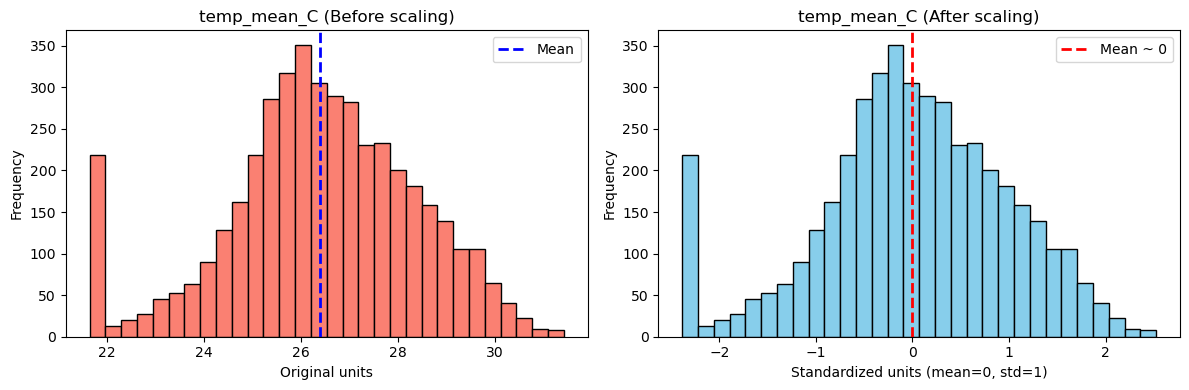

In [23]:
import matplotlib.pyplot as plt

# Continuous features to check
continuous_features = [
    "temp_mean_C","temp_max_C","temp_min_C",
    "rain_sum","sunshine_duration","daylight_duration",
    "wind_speed_max","et0_evapotranspiration"
]
continuous_features = [c for c in continuous_features if c in df_ohe.columns]

# Pick one feature to visualize
feature = "temp_mean_C"   # change this to try others

fig, ax = plt.subplots(1, 2, figsize=(12, 4))

# --- Before scaling ---
ax[0].hist(df_ohe[feature].dropna(), bins=30, edgecolor="black", color="salmon")
ax[0].set_title(f"{feature} (Before scaling)")
ax[0].set_xlabel("Original units")
ax[0].set_ylabel("Frequency")
ax[0].axvline(df_ohe[feature].mean(), color="blue", linestyle="dashed", linewidth=2, label="Mean")
ax[0].legend()

# --- After scaling ---
ax[1].hist(df_scaled[feature].dropna(), bins=30, edgecolor="black", color="skyblue")
ax[1].set_title(f"{feature} (After scaling)")
ax[1].set_xlabel("Standardized units (mean=0, std=1)")
ax[1].set_ylabel("Frequency")
ax[1].axvline(df_scaled[feature].mean(), color="red", linestyle="dashed", linewidth=2, label="Mean ~ 0")
ax[1].legend()

plt.tight_layout()
plt.show()


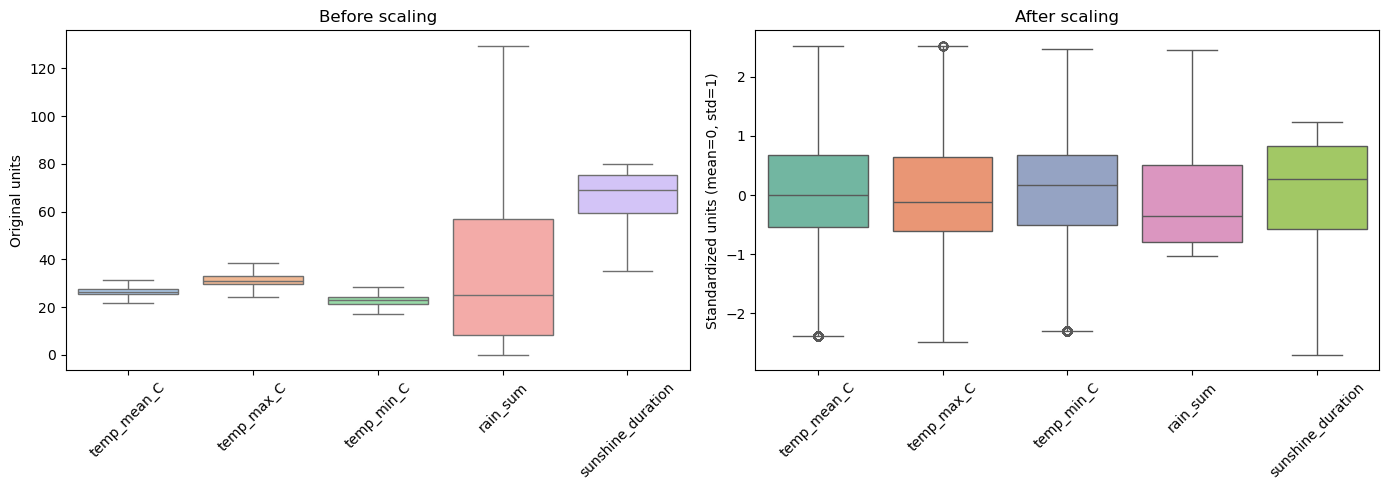

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define continuous features (skip dummies and target)
continuous_features = [
    "temp_mean_C","temp_max_C","temp_min_C",
    "rain_sum","sunshine_duration","daylight_duration",
    "wind_speed_max","et0_evapotranspiration"
]
continuous_features = [c for c in continuous_features if c in df_ohe.columns]

# Sample: take first 5 features for side-by-side comparison
sample_features = continuous_features[:5]

fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# --- Before scaling ---
sns.boxplot(data=df_ohe[sample_features], ax=ax[0], palette="pastel")
ax[0].set_title("Before scaling")
ax[0].set_ylabel("Original units")
ax[0].tick_params(axis='x', rotation=45)

# --- After scaling ---
sns.boxplot(data=df_scaled[sample_features], ax=ax[1], palette="Set2")
ax[1].set_title("After scaling")
ax[1].set_ylabel("Standardized units (mean=0, std=1)")
ax[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


In [25]:
# Drop 'yearweek' column (case-insensitive, handles variants safely)
cols_to_drop = [c for c in df_scaled.columns if c.lower() in {"yearweek", "year_week"}]

df = df_scaled.drop(columns=cols_to_drop, errors="ignore")

print("✅ Dropped:", cols_to_drop if cols_to_drop else "No 'yearweek' column found")
print("Remaining columns:", df.columns.tolist())

✅ Dropped: ['YearWeek']
Remaining columns: ['temp_mean_C', 'temp_max_C', 'temp_min_C', 'rain_sum', 'sunshine_duration', 'daylight_duration', 'wind_speed_max', 'et0_evapotranspiration', 'District_anuradhapura', 'District_badulla', 'District_batticaloa', 'District_colombo', 'District_galle', 'District_gampaha', 'District_hambantota', 'District_jaffna', 'District_kalmunai', 'District_kalutara', 'District_kandy', 'District_kegalle', 'District_kilinochchi', 'District_kurunegala', 'District_mannar', 'District_matale', 'District_matara', 'District_monaragala', 'District_mullaitivu', 'District_nuwara eliya', 'District_polonnaruwa', 'District_puttalam', 'District_ratnapura', 'District_trincomalee', 'District_vavuniya', 'risk_level']


In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

In [27]:
df = df.drop(columns=["YearWeek"], errors="ignore")
print("✅ Dropped 'YearWeek' column")
print("Remaining columns:", df.columns.tolist())

✅ Dropped 'YearWeek' column
Remaining columns: ['temp_mean_C', 'temp_max_C', 'temp_min_C', 'rain_sum', 'sunshine_duration', 'daylight_duration', 'wind_speed_max', 'et0_evapotranspiration', 'District_anuradhapura', 'District_badulla', 'District_batticaloa', 'District_colombo', 'District_galle', 'District_gampaha', 'District_hambantota', 'District_jaffna', 'District_kalmunai', 'District_kalutara', 'District_kandy', 'District_kegalle', 'District_kilinochchi', 'District_kurunegala', 'District_mannar', 'District_matale', 'District_matara', 'District_monaragala', 'District_mullaitivu', 'District_nuwara eliya', 'District_polonnaruwa', 'District_puttalam', 'District_ratnapura', 'District_trincomalee', 'District_vavuniya', 'risk_level']


In [28]:
# Separate target and features ---
assert "risk_level" in df.columns, "Target column 'risk_level' not found!"
y = df["risk_level"].astype(int)
X_scaled = df.drop(columns=["risk_level"]).values  # scaled features

print("Shape of features (scaled):", X_scaled.shape)
print("Shape of target:", y.shape)

Shape of features (scaled): (4366, 33)
Shape of target: (4366,)


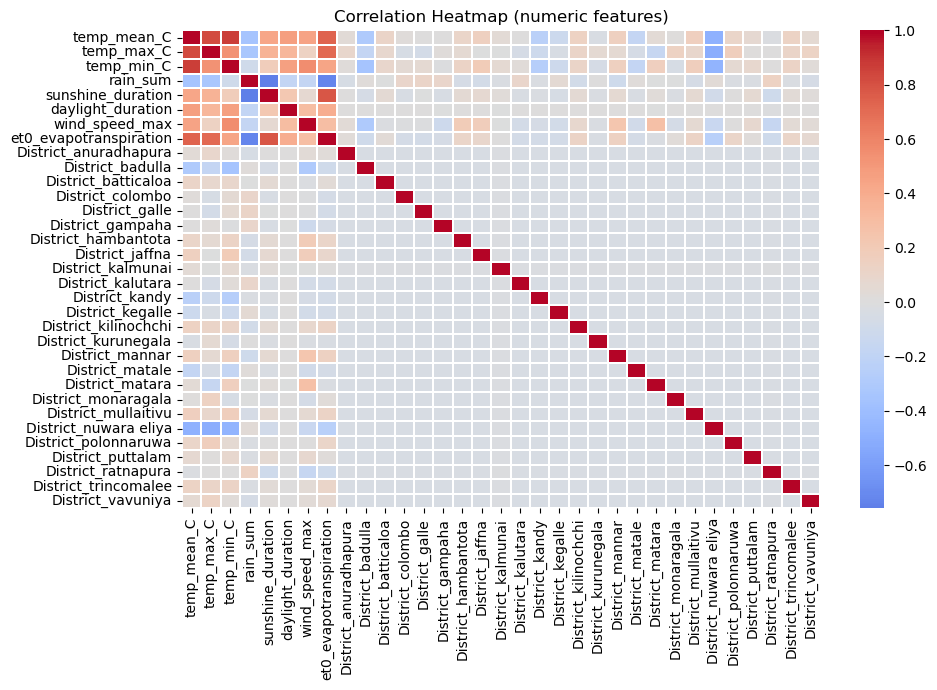

In [29]:
# EDA: Correlation Heatmap ---
plt.figure(figsize=(10, 7))
corr = df.drop(columns=["risk_level"]).corr(numeric_only=True)
sns.heatmap(corr, cmap="coolwarm", center=0, linewidths=0.3)
plt.title("Correlation Heatmap (numeric features)")
plt.tight_layout()
plt.show()

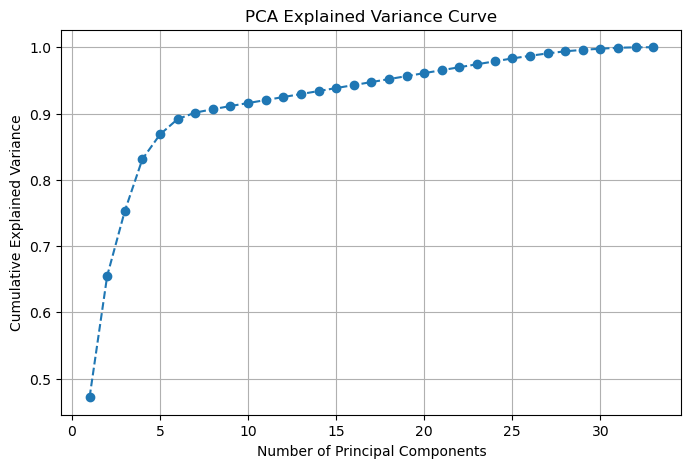

In [30]:
pca_full = PCA()
pca_full.fit(X_scaled)

explained_var = pca_full.explained_variance_ratio_
cum_var = np.cumsum(explained_var)

# Variance curve
plt.figure(figsize=(8,5))
plt.plot(range(1, len(cum_var)+1), cum_var, marker="o", linestyle="--")
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA Explained Variance Curve")
plt.grid(True)
plt.show()

In [31]:
k = int(np.argmax(cum_var >= 0.90)) + 1
print(f"✅ Keeping {k} principal components (cover ≥90% variance)")

# Apply PCA with selected k ---
pca = PCA(n_components=k)
X_pca = pca.fit_transform(X_scaled)

print("PCA-transformed shape:", X_pca.shape)

# Build PCA DataFrame with target ---
pca_df = pd.DataFrame(X_pca, columns=[f"PC{i}" for i in range(1, k+1)])
pca_df["risk_level"] = y.values


✅ Keeping 7 principal components (cover ≥90% variance)
PCA-transformed shape: (4366, 7)


In [32]:
# Save to CSV ---
output_file = "DengueRisk_Final_processed_dataset.csv"
pca_df.to_csv(output_file, index=False)
print(f"✅ Saved PCA dataset to {output_file}")


✅ Saved PCA dataset to DengueRisk_Final_processed_dataset.csv


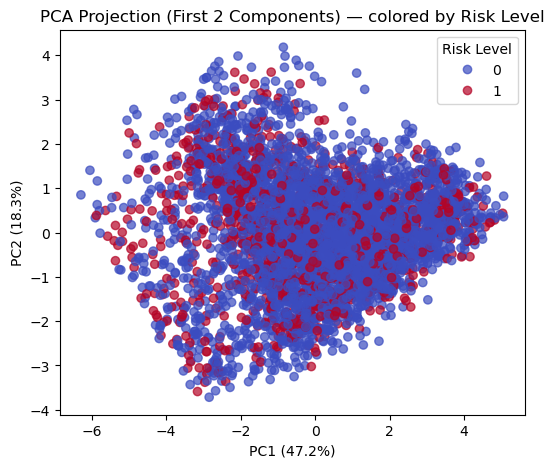

In [33]:
# 2D PCA scatter plot ---
if X_pca.shape[1] >= 2:
    plt.figure(figsize=(6,5))
    scatter = plt.scatter(X_pca[:,0], X_pca[:,1], c=y, cmap="coolwarm", alpha=0.7)
    plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)")
    plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)")
    plt.title("PCA Projection (First 2 Components) — colored by Risk Level")
    plt.legend(*scatter.legend_elements(), title="Risk Level")
    plt.show()